In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
!pip install -q transformers==4.20.0
!pip install -q datasets torchvision pycocotools accelerate

In [4]:
from huggingface_hub import login
from google.colab import userdata
token = userdata.get('Nyi_token')
login(token=token)

In [5]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor, Trainer, TrainingArguments
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Hugging Face
!ls

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1OAwQPoxfnPPp90tlzRE1fTmfB377ksLA/Hugging Face
lightning_logs			   SegFormer_Huggingface_seg.ipynb
markerpensseg			   segformer_trained_weights
Markerpens_seg			   segformer_trained_weights_47
mask2former_Huggingface_seg.ipynb  YOLOS_Huggingface_det.ipynb
mask2formerresults		   YOLOS_Huggingface_det_wandb.ipynb
mydrive


In [7]:
class CocoInstanceDataset(Dataset):
    def __init__(self, annotation_file, image_root, processor):
        self.coco = COCO(annotation_file)
        self.image_root = image_root
        self.image_ids = list(self.coco.imgs.keys())
        self.processor = processor
        # Create a mapping from category ID to a continuous label index starting from 0
        categories = self.coco.loadCats(self.coco.getCatIds())
        self.cat2label = {cat['id']: i for i, cat in enumerate(categories)}
        self.label2cat = {i: cat['id'] for i, cat in enumerate(categories)} # Optional: for mapping back

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(image_id)[0]
        img_path = os.path.join(self.image_root, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        masks = []
        class_labels = []

        for ann in anns:
            # Ensure the category ID is in your mapping, otherwise skip
            if ann['category_id'] not in self.cat2label:
                continue

            if isinstance(ann['segmentation'], list):  # polygon format
                rle = mask_utils.frPyObjects(ann['segmentation'], img_info['height'], img_info['width'])
                rle = mask_utils.merge(rle)
            else:
                rle = ann['segmentation']  # in case it's already RLE

            # Decode RLE and convert to boolean tensor
            mask = torch.tensor(mask_utils.decode(rle)).squeeze().bool()
            masks.append(mask)
            # Use the mapped label index
            class_labels.append(self.cat2label[ann['category_id']])

        # Ensure shape (num_instances, H, W)
        if masks:
            masks = torch.stack(masks)
        else:
            masks = torch.zeros((0, img_info['height'], img_info['width']), dtype=torch.bool)

        class_labels = torch.tensor(class_labels, dtype=torch.int64)

        # Process the image. This handles resizing and normalization.
        # Note: We are NOT passing masks and class_labels to the processor here
        # as the model expects them separately after collation for training.
        encoded_inputs = self.processor(images=image, return_tensors="pt")

        # The dataset item should return the processed image data,
        # and the masks and class labels separately for the collator.
        return {
            "pixel_values": encoded_inputs["pixel_values"].squeeze(0),
            "pixel_mask": encoded_inputs["pixel_mask"].squeeze(0),
            "mask_labels": masks.float(), # Return the raw masks
            "class_labels": class_labels, # Return the raw class labels
        }

In [9]:
# Prepare processor and model
processor = Mask2FormerImageProcessor.from_pretrained("facebook/mask2former-swin-small-coco-instance")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-coco-instance")

In [10]:
# Load datasets (set paths accordingly)
train_dataset = CocoInstanceDataset(
    annotation_file="markerpensseg/train/_annotations.coco.json",
    image_root="markerpensseg/train",
    processor=processor
)
eval_dataset = CocoInstanceDataset(
    annotation_file="markerpensseg/valid/_annotations.coco.json",
    image_root="markerpensseg/valid",
    processor=processor
)

loading annotations into memory...
Done (t=3.68s)
creating index...
index created!
loading annotations into memory...
Done (t=0.91s)
creating index...
index created!


In [11]:
training_args = TrainingArguments(
    output_dir="./mask2formerresults/mask2former-custom",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    fp16=True,
    logging_dir="./mask2formerresults/logs",
    report_to="none"
)

In [12]:
# Define custom data collator
def collate_fn(samples):
    # Stack pixel values and pixel masks as these have fixed dimensions
    pixel_values = torch.stack([s["pixel_values"] for s in samples])
    pixel_mask = torch.stack([s["pixel_mask"] for s in samples])

    # Mask and class labels have variable dimensions (number of instances),
    # so they should be returned as lists of tensors
    mask_labels = [s["mask_labels"] for s in samples]
    class_labels = [s["class_labels"] for s in samples]

    return {
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
        "mask_labels": mask_labels,
        "class_labels": class_labels,
    }

In [ ]:
# Train model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,13.547791
2,No log,13.303618
3,No log,13.680099
4,No log,13.877213
5,No log,13.968730


TrainOutput(global_step=285, training_loss=7.327724952028508, metrics={'train_runtime': 492.3012, 'train_samples_per_second': 2.285, 'train_steps_per_second': 0.579, 'total_flos': 2.05100011892736e+17, 'train_loss': 7.327724952028508, 'epoch': 5.0})

In [ ]:
sample = eval_dataset[0]
inputs = {
    k: v.unsqueeze(0).to(model.device) for k, v in sample.items() if k in ['pixel_values', 'pixel_mask']
}

with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

Mask2FormerForUniversalSegmentationOutput(loss={'class_queries_logits': tensor([[[ -3.7148,  -3.1758,  -5.8594,  ..., -11.7500,  -8.4844,  10.1016],
         [ -3.7363,  -3.6035,  -5.7500,  ..., -11.6484,  -8.7656,  10.2031],
         [ -3.5215,  -3.5605,  -5.3906,  ..., -12.4062,  -8.3047,   9.9453],
         ...,
         [ -3.6367,  -3.4590,  -4.9883,  ..., -11.5703,  -8.8438,   9.7500],
         [ -3.5625,  -2.6797,  -5.5273,  ..., -11.9609,  -8.6953,   9.9844],
         [ -3.5352,  -3.5859,  -4.8789,  ..., -11.4766,  -8.7578,   9.6016]]],
       device='cuda:0'), 'masks_queries_logits': tensor([[[[ -74.9375, -104.0625,  -96.1250,  ...,  -83.5000, -105.4375,
            -83.5000],
          [ -83.2500,  -77.6250,  -74.5000,  ...,  -59.7500,  -87.3125,
            -80.1250],
          [ -75.1250,  -75.3125,  -70.4375,  ...,  -56.1250,  -94.1875,
            -77.0625],
          ...,
          [ -84.5625,  -82.8750,  -69.6875,  ...,  -97.8750, -112.3750,
            -89.6250],
      

In [13]:
print("label2cat:", eval_dataset.label2cat)

label2cat: {0: 0, 1: 1}


In [16]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import pycocotools.mask as mask_utils
import numpy as np
import torch
import cv2
import json
import os
from tqdm import tqdm

@torch.no_grad()
def evaluate_model_on_validation(model, dataset, processor, score_threshold=0.1, device="cuda"):
    model.eval()
    model.to(device)

    results = []
    print("Evaluating on validation set...")

    for idx in tqdm(range(len(dataset))):
        sample = dataset[idx]
        pixel_values = sample['pixel_values'].unsqueeze(0).to(device)

        image_id = dataset.image_ids[idx]
        image_info = dataset.coco.loadImgs(image_id)[0]
        height, width = image_info['height'], image_info['width']

        outputs = model(pixel_values=pixel_values)
        try:
            pred_logits = outputs.class_queries_logits[0]  # [num_queries, num_classes]
            pred_masks = outputs.masks_queries_logits[0].sigmoid() > 0.5  # [num_queries, H, W]
        except AttributeError:
            print("❌ Model output keys are incorrect.")
            return

        probs = pred_logits.softmax(-1)[:, :-1]  # remove 'no object' class
        scores, labels = probs.max(-1)

        keep = scores > score_threshold
        if keep.sum() == 0:
            continue

        scores = scores[keep]
        labels = labels[keep]
        masks = pred_masks[keep]

        for i in range(len(masks)):
            mask = masks[i].cpu().numpy().astype(np.uint8)
            if mask.shape != (height, width):
                mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)

            rle = mask_utils.encode(np.asfortranarray(mask))
            rle["counts"] = rle["counts"].decode("utf-8")  # COCO expects string

            category_id = dataset.label2cat[labels[i].item()]  # Map back to original category_id
            result = {
                "image_id": image_id,
                "category_id": category_id,
                "segmentation": rle,
                "score": float(scores[i].item()),
            }
            results.append(result)

    if not results:
        print("⚠️ No predictions passed threshold!")
        return {"precision": 0, "recall": 0, "f1": 0}

    print(f"✅ {len(results)} predictions prepared for evaluation")

    # Save results temporarily
    pred_path = "temp_predictions.json"
    with open(pred_path, "w") as f:
        json.dump(results, f)

    coco_gt = dataset.coco
    coco_dt = coco_gt.loadRes(pred_path)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="segm")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Clean up temp file
    os.remove(pred_path)

    precision = coco_eval.stats[0]
    recall = coco_eval.stats[8]
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    print(f"\n🔍 Evaluation Metrics:\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}")
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [51]:
import os
import re
from transformers import Mask2FormerForUniversalSegmentation

checkpoint_root = "mask2formerresults/mask2former-custom"
checkpoints = sorted(
    [d for d in os.listdir(checkpoint_root) if re.match(r"^checkpoint-\d+$", d)],
    key=lambda x: int(x.split("-")[1])
)

results = {}

for ckpt in checkpoints:
    print(f"\nEvaluating {ckpt}...")
    model_path = os.path.join(checkpoint_root, ckpt)
    model = Mask2FormerForUniversalSegmentation.from_pretrained(model_path).to("cuda")

    metrics = evaluate_model_on_validation(model, dataset=eval_dataset, processor=processor, score_threshold=0.5)
    results[ckpt] = metrics

print("\n📊 Summary of All Checkpoints:")
for ckpt, metrics in results.items():
    print(f"{ckpt}: F1={metrics['f1']:.4f}, Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}")

# Find checkpoint with highest F1
best_ckpt = max(results.items(), key=lambda x: x[1]['f1'])
print(f"\n🏆 Best checkpoint based on F1 score: {best_ckpt[0]} with F1={best_ckpt[1]['f1']:.4f}")


Evaluating checkpoint-57...
Evaluating on validation set...


100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


✅ 60 predictions prepared for evaluation
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.968
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.968
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.772
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Recall     (AR) 

100%|██████████| 30/30 [00:05<00:00,  5.29it/s]


✅ 60 predictions prepared for evaluation
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.749
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.966
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.966
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.775
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Recall     (AR) 

100%|██████████| 30/30 [00:06<00:00,  4.51it/s]


✅ 59 predictions prepared for evaluation
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.734
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.945
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.945
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.734
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.762
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.762
 Average Recall     (AR) 

100%|██████████| 30/30 [00:05<00:00,  5.31it/s]


✅ 60 predictions prepared for evaluation
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.964
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.964
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.748
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.775
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Recall     (AR) 

100%|██████████| 30/30 [00:06<00:00,  4.77it/s]

✅ 60 predictions prepared for evaluation
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.965
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.965
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.777
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Recall     (AR) 

In [23]:
@torch.no_grad()
def visualize_mask2former_predictions(model, processor, dataset, device="cuda", score_threshold=0.5, num_images=3):
    import matplotlib.pyplot as plt
    import numpy as np
    import random
    import cv2
    from PIL import Image
    import os
    import torch
    import torchvision.transforms.functional as TF

    model.eval()
    model.to(device)

    # Map label index (0-based) to category name via dataset.cat2label and COCO
    coco = dataset.coco
    label2catid = {v: k for k, v in dataset.cat2label.items()}  # reverse map label idx -> category_id
    label2name = {label: coco.loadCats(cat_id)[0]['name'] for label, cat_id in label2catid.items()}

    for idx in range(num_images):
        sample = dataset[idx]
        pixel_values = sample['pixel_values'].unsqueeze(0).to(device)  # (1,3,H,W)

        outputs = model(pixel_values=pixel_values)
        # Skip if model returned None
        if outputs is None or not hasattr(outputs, "pred_logits"):
            print("Model output is None or missing 'pred_logits'")
            continue

        # Extract logits and mask logits
        class_logits = outputs.loss['class_queries_logits']  # (1, num_queries, num_classes)
        mask_logits = outputs.loss['masks_queries_logits']   # (1, num_queries, H_mask, W_mask)

        class_probs = class_logits.softmax(-1)[0, :, :-1]  # (num_queries, num_classes), remove no-object class
        scores, labels = class_probs.max(-1)  # best class score and label for each query

        masks = mask_logits.sigmoid()[0]  # (num_queries, H_mask, W_mask)

        # Filter by score threshold
        keep = scores > score_threshold
        scores = scores[keep]
        labels = labels[keep]
        masks = masks[keep]

        # Resize masks to original image size
        # Original image size
        image_id = dataset.image_ids[idx]
        img_info = coco.loadImgs(image_id)[0]
        orig_image = np.array(Image.open(os.path.join(dataset.image_root, img_info['file_name'])).convert("RGB"))
        H, W = orig_image.shape[:2]

        masks_resized = torch.nn.functional.interpolate(
            masks.unsqueeze(1), size=(H, W), mode="bilinear", align_corners=False
        ).squeeze(1)

        # Binarize masks
        masks_bin = masks_resized > 0.5  # (num_masks, H, W)

        overlay = orig_image.copy()

        # --- FIRST PASS: DRAW MASKS ---
        for i in range(len(masks_bin)):
            mask = masks_bin[i].cpu().numpy().astype(np.uint8)
            class_id = labels[i].item()
            score = scores[i].item()
            color = [0, 255, 0]
            alpha = 0.5

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for cnt in contours:
                mask_cnt = np.zeros((H, W), dtype=np.uint8)
                cv2.drawContours(mask_cnt, [cnt], -1, 255, thickness=cv2.FILLED)
                mask_bool = mask_cnt.astype(bool)
                overlay[mask_bool] = (
                    alpha * np.array(color) + (1 - alpha) * overlay[mask_bool]
                ).astype(np.uint8)

        # --- SECOND PASS: DRAW TEXT ---
        for i in range(len(masks_bin)):
            mask = masks_bin[i].cpu().numpy().astype(np.uint8)
            class_id = labels[i].item()
            label = label2name.get(class_id, f"class_{class_id}")
            score = scores[i].item()

            M = cv2.moments(mask)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.putText(overlay, f"{label} ({score:.2f})", (cX-50, cY-50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 4, cv2.LINE_AA)

        plt.figure(figsize=(12, 6))
        plt.imshow(overlay)
        plt.title(f"Predicted Masks with Labels (Score > {score_threshold})")
        plt.axis("off")
        plt.show()

In [48]:
@torch.no_grad()
def visualize_mask2former_predictions_final(model, processor, dataset, device="cuda", score_threshold=0.5, num_images=3):
    import matplotlib.pyplot as plt
    import numpy as np
    import cv2
    from PIL import Image
    import torch
    import os
    import torch.nn.functional as F

    model.eval()
    model.to(device)

    # Get label name mapping
    coco = dataset.coco
    label2name = {v: coco.loadCats(cat_id)[0]['name'] for cat_id, v in dataset.cat2label.items()}
    # Fixed list of 5 BGR colors (for OpenCV)
    color_palette = [
                    [0, 255, 0],     # green
                    [255, 255, 0],   # cyan
                    [255, 0, 0],     # blue
                    [0, 255, 255],   # yellow
                    [255, 0, 255],   # purple
                ]

    for idx in range(num_images):
        sample = dataset[idx]
        pixel_values = sample['pixel_values'].unsqueeze(0).to(device)

        # Load original image to get H, W
        image_id = dataset.image_ids[idx]
        img_info = coco.loadImgs(image_id)[0]
        img_path = os.path.join(dataset.image_root, img_info['file_name'])
        orig_image = np.array(Image.open(img_path).convert("RGB"))
        H, W = orig_image.shape[:2]
        overlay = orig_image.copy()

        # Run model
        outputs = model(pixel_values=pixel_values)
        class_logits = outputs.class_queries_logits[0]  # [num_queries, num_classes]
        mask_logits = outputs.masks_queries_logits[0]   # [num_queries, H_pred, W_pred]

        # Process logits
        probs = class_logits.softmax(-1)[:, :-1]  # remove "no object" class
        scores, labels = probs.max(-1)
        keep = scores > score_threshold

        scores = scores[keep]
        labels = labels[keep]

        # Resize masks to original image size
        mask_logits = F.interpolate(
            mask_logits.unsqueeze(0),  # add batch
            size=(H, W),
            mode="bilinear",
            align_corners=False
        )[0]  # remove batch

        masks = mask_logits[keep].sigmoid() > 0.5
        masks_bin = masks.cpu()

        alpha = 0.5

        # --- FIRST PASS: DRAW MASKS ---
        for i in range(len(masks_bin)):
            mask = masks_bin[i].numpy().astype(np.uint8)
            class_id = labels[i].item()
            score = scores[i].item()
            color = color_palette[i % len(color_palette)]

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                mask_cnt = np.zeros((H, W), dtype=np.uint8)
                cv2.drawContours(mask_cnt, [cnt], -1, 255, thickness=cv2.FILLED)
                mask_bool = mask_cnt.astype(bool)
                overlay[mask_bool] = (
                    alpha * np.array(color) + (1 - alpha) * overlay[mask_bool]
                ).astype(np.uint8)
              # Draw bounding box around the contour
                x, y, w, h = cv2.boundingRect(cnt)
                cv2.rectangle(overlay, (x, y), (x + w, y + h), color, thickness=2)

        # --- SECOND PASS: DRAW TEXT ---
        for i in range(len(masks_bin)):
            mask = masks_bin[i].numpy().astype(np.uint8)
            class_id = labels[i].item()
            label = label2name.get(class_id, f"class_{class_id}")
            score = scores[i].item()

            M = cv2.moments(mask)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                cv2.putText(overlay, f"{label} ({score:.2f})", (cX - 50, cY - 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 4, cv2.LINE_AA)

        # Show result
        plt.figure(figsize=(12, 6))
        plt.imshow(overlay)
        plt.title(f"Predicted Masks (Score > {score_threshold})")
        plt.axis("off")
        plt.show()

In [32]:
from transformers import Mask2FormerForUniversalSegmentation

model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "mask2formerresults/mask2former-custom/checkpoint-285",
    config="mask2formerresults/mask2former-custom/checkpoint-285"
).to("cuda")
model.eval()

# Sanity test
dummy = eval_dataset[0]
pixel_values = dummy["pixel_values"].unsqueeze(0).to("cuda")

with torch.no_grad():
    out = model(pixel_values=pixel_values)

print("Output keys:", out.keys() if out is not None else "None")
print("class_queries_logits shape:", out.class_queries_logits.shape)
print("masks_queries_logits shape:", out.masks_queries_logits.shape)

Output keys: odict_keys(['class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state'])
class_queries_logits shape: torch.Size([1, 100, 81])
masks_queries_logits shape: torch.Size([1, 100, 96, 96])


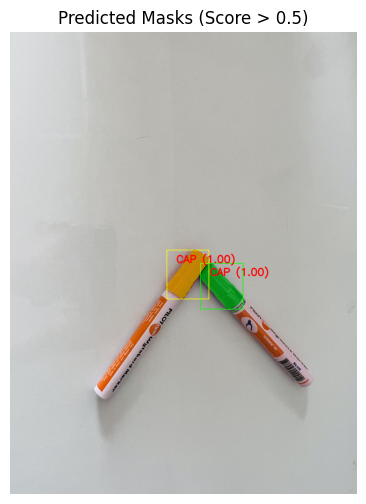

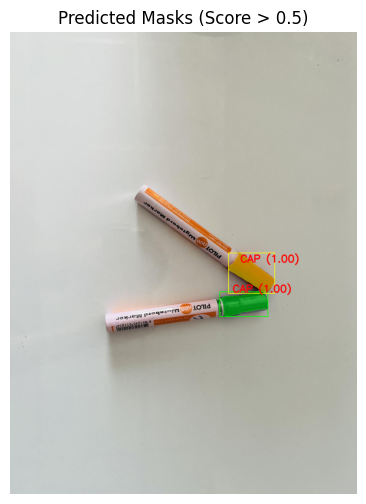

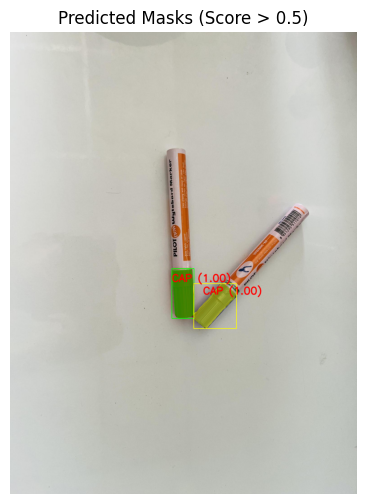

In [49]:
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "mask2formerresults/mask2former-custom/checkpoint-285",
    config="mask2formerresults/mask2former-custom/checkpoint-285"
).to("cuda")
#print(model)
visualize_mask2former_predictions_final(
    model=model,
    processor=processor,
    dataset=eval_dataset,
    device="cuda",  # or "cpu"
    score_threshold=0.5,
    num_images=3
)